# Semantic analysis of Twitch livestream chat terms using word vectors

**DISCLAIMER**: I am not responsible in any way for the content of the dataset itself, which includes offensive and/or derogatory language. A copy of the dataset can be obtained from https://osf.io/39ev7.

In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim.models import word2vec, fasttext
import glob
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

C:\Users\brandon\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1. Preprocessing and Examining the Dataset

The dataset consists of a series of CSV files with anonymized user ID and message data.

In [5]:
csv_files = [file for file in glob.glob('D:/Users/brandon/data_set/data/*.csv')]

In [6]:
pd.read_csv(csv_files[10]).head(100)

,Time,User,Message
0,0.0,2478b9f9b54fadbad63b1b4e84331a65d165ddf1,i'd go with filthy plebe
1,13.0,c156cc17ae18d228f16d662e4e7c5d53601bcdf8,little above casual
2,51.0,cef31dad87dd5ea1659c8602621de7922ca91b56,4/6 is like addicting school boy
3,84.0,aebfb843f2b1e3b7f3cf72b573321f9b0fd1dd63,behind you it says you're in queue
4,87.0,a10cf07c115e046f1165fa75345c563ca6e2ff67,you not on ferlina
...,...,...,...
95,3075.0,dd3ac56dba170017de2b3bf2846b7ed8d288ccbb,we didn't get a chance to xd
96,3089.0,4beb92fa20ff6ffff86f724bc8265c8508819260,no
97,3094.0,5aea5a285545be5dc31353b84b5f93a5213abf46,i was sending ammosploshin after awhile didn't...
98,3129.0,d2d38c15edc1225819d9fe02d9ec66f9a0eb0377,they should totally give better loot after all...


As seen above, clearly the data does not consist of complete sentences—in fact, there is misspelling even among Twitch-specific/non-prosaic terms (for example, *poogers* instead of *poggers* in message 18).

**Concatenating the CSV file data frames**

We proceed to concatenate the CSV files provided into one large data frame, maintaining a unique key for each file.

In [7]:
csv_dfs = [pd.read_csv(file_path) for file_path in tqdm(csv_files)]
data = pd.concat(csv_dfs, keys=[i for i in range(len(csv_dfs))]) # Associated key with each original CSV file

100%|██████████| 1951/1951 [01:20<00:00, 24.27it/s]


In [8]:
data

Time                                      User  \
0    0       0.0  c57408f5ed00cc1bd11a04622cad08a16549f988   
     1      19.0  013e821f4abd3315b33607ba2cb49e56f79ab646   
     2      20.0  8b0b3e7ab08aa054e442e2b541b9ccae3301da60   
     3      32.0  5f3e0747f3e4f0220d696078ff84d37431be2682   
     4      32.0  c57408f5ed00cc1bd11a04622cad08a16549f988   
...          ...                                       ...   
1950 630  3234.0  b616d7bfe22f02a210d4ad732160d006824c6607   
     631  3235.0  7e7bf37c9889c635dbb66f8cd4fb926b039ceb07   
     632  3236.0  075b77801ab50ed6f9f30f30510804deaf73e1c7   
     633  3246.0  ba083faf1e4a03ebbc09c1a240b25563365cdea2   
     634  3349.0  258eb86ae2c11502d97d748b4aab58ee5a87f1f2   

                                                    Message  
0    0    this is the problem with d1 rewards no consuma...  
     1    imagine doing this on a proper road to glory k...  
     2                    can someone help me with trading   
     3                        5110 people in here pogchamp   
     4    just chuck a few rare consumable packs in the ...  
...                                                     ...  
1950 630                                               sup   
     631  finicksquad finicksquad finicksquad finicksqua...  
     632                                     whats up bruh   
     633            im blueee aba dee abadaa abaeee abadaa   
     634                                any scrims tonight   

[14720748 rows x 3 columns]

In [9]:
messages = list(data["Message"])[:1000000] # Extracting the message data...
tokens = [nltk.word_tokenize(message) for message in tqdm(messages)]
tokens[:10]

100%|██████████| 1000000/1000000 [01:49<00:00, 9170.30it/s]


[['this',
  'is',
  'the',
  'problem',
  'with',
  'd1',
  'rewards',
  'no',
  'consumables'],
 ['imagine',
  'doing',
  'this',
  'on',
  'a',
  'proper',
  'road',
  'to',
  'glory',
  'kappa'],
 ['can', 'someone', 'help', 'me', 'with', 'trading'],
 ['5110', 'people', 'in', 'here', 'pogchamp'],
 ['just',
  'chuck',
  'a',
  'few',
  'rare',
  'consumable',
  'packs',
  'in',
  'the',
  'rewards',
  'you',
  'stingy',
  'fucks'],
 ['i', 'have', '50k'],
 ['league', 'sbccccccccccc'],
 ['they', 'call', 'me', 'unexpected'],
 ['2million', 'coins'],
 ['way', 'tooooo', 'much']]

In [10]:
def trim_rule(word, count, min_count): # Trim unnecessary words from vocabulary
    if(count < min_count):
        return gensim.utils.RULE_DISCARD
    if(len(word) > 30): # Probably a UUID or some anonymized Twitch username, or a string of characters that is not common
        return gensim.utils.RULE_DISCARD
    if(not word.isascii()):
        return gensim.utils.RULE_DISCARD
    
    return gensim.utils.RULE_KEEP

# 2. Using word2vec

In [63]:
untrained_w2v_model = word2vec.Word2Vec.load('D:\\Users\\brandon\\1billion_word_vectors\\1billion_word_vectors') # Use a pretrained model as a baseline, taken from the course notes

In [26]:
w2v_model = word2vec.Word2Vec.load('D:\\Users\\brandon\\1billion_word_vectors\\1billion_word_vectors') # Use a pretrained model as a baseline, taken from the course notes
w2v_model.build_vocab(tokens, update=True, trim_rule=trim_rule)

# w2v_model = word2vec.Word2Vec(vector_size=20, window=5, min_count=1, workers=4)
# w2v_model.build_vocab(tokens, trim_rule=trim_rule)

w2v_model.train(tokens, total_examples=len(tokens), epochs=10)

Loading model...
Beginning training...


(37818699, 46784870)

In [71]:
w2v_model.wv.most_similar('xd', topn=50) # A word commonly used on Twitch but not in other real-world formal corpora

[('lulw', 0.6382310390472412),
 ('lol', 0.6154484152793884),
 ('kappa', 0.6136361956596375),
 ('lmao', 0.6008146405220032),
 ('kekw', 0.5870595574378967),
 ('lul', 0.5701726675033569),
 ('dansgame', 0.5593599677085876),
 ('tho', 0.5465115308761597),
 ('weirdchamp', 0.5296686887741089),
 ('snek', 0.5277909636497498),
 ('pepelaugh', 0.5238629579544067),
 ('monkahmm', 0.5205404758453369),
 ('misdirection', 0.5142325758934021),
 ('kapp', 0.5119029879570007),
 ('self-aggrandising', 0.5109595060348511),
 ('fuckin', 0.5107264518737793),
 ('5head', 0.5017266869544983),
 ('merely', 0.49929624795913696),
 ('wtff', 0.4981774687767029),
 ('moon2s', 0.4932005703449249),
 ('monkas', 0.49235132336616516),
 ('sensationalism', 0.4888674020767212),
 ('self-justifying', 0.48612380027770996),
 ('rofl', 0.4850550889968872),
 ('krappa', 0.48500391840934753),
 ('sophomoric', 0.48472562432289124),
 ('methinks', 0.48347723484039307),
 ('alicopter', 0.4833369851112366),
 ('lyngo', 0.4822123944759369),
 ('haha',

In [29]:
w2v_model.wv.most_similar('multiplicity', topn=20) # A word common in real-world corpora but rarely used on Twitch

[('multitude', 0.7894293665885925),
 ('plethora', 0.7361137866973877),
 ('myriad', 0.7274970412254333),
 ('panoply', 0.7130789160728455),
 ('hodgepodge', 0.7072940468788147),
 ('mishmash', 0.6865152716636658),
 ('welter', 0.6864110827445984),
 ('profusion', 0.6661581993103027),
 ('concatenation', 0.6619635820388794),
 ('cornucopia', 0.653671145439148),
 ('mish-mash', 0.6526468992233276),
 ('wide-range', 0.6480439901351929),
 ('paucity', 0.6439318060874939),
 ('confluence', 0.6388809084892273),
 ('compendium', 0.6295364499092102),
 ('surfeit', 0.621500551700592),
 ('convergence', 0.6179296374320984),
 ('distillation', 0.6139135360717773),
 ('preponderance', 0.6078886389732361),
 ('litany', 0.6066928505897522)]

In [82]:
w2v_model.wv.most_similar('buff', topn=20) # A word common in real-world corpora but rarely used on Twitch

[('nerf', 0.5966935157775879),
 ('stylist', 0.5850667357444763),
 ('restorer', 0.5589324235916138),
 ('magician', 0.5580945014953613),
 ('stuntman', 0.5545908808708191),
 ('square-jawed', 0.5499854683876038),
 ('enthusiast', 0.5492820143699646),
 ('aficionado', 0.5469423532485962),
 ('near-obsessive', 0.5435566306114197),
 ('clean-cut', 0.5389794111251831),
 ('fast-talking', 0.5348868370056152),
 ('pipe-smoking', 0.5348659157752991),
 ('deerstalker', 0.5339064002037048),
 ('cigar-chomping', 0.5291764736175537),
 ('grifter', 0.5288669466972351),
 ('craftsman', 0.5275900363922119),
 ('tough-guy', 0.5263129472732544),
 ('aviator', 0.5258749723434448),
 ('fetishist', 0.5255516171455383),
 ('conceptualist', 0.5249803066253662)]

In [110]:
w2v_model.wv.most_similar('damage', topn=20) # A word common in both real-world contexts and Twitch usage

[('dmg', 0.7448021173477173),
 ('harm', 0.6215290427207947),
 ('disruption', 0.6062285900115967),
 ('damage.', 0.5966753959655762),
 ('scarring', 0.5891187787055969),
 ('corrosion', 0.5808465480804443),
 ('casualties', 0.5680224895477295),
 ('subsidence', 0.5677663087844849),
 ('injuries.', 0.5662626028060913),
 ('catastrophes', 0.5573567748069763),
 ('toxicities', 0.5573274493217468),
 ('injuries', 0.554681122303009),
 ('disruptions', 0.5459778308868408),
 ('degradation', 0.5425095558166504),
 ('complications', 0.5411633253097534),
 ('hazards', 0.5407196879386902),
 ('shrinkage', 0.5280895829200745),
 ('ruptures', 0.5274685621261597),
 ('pollution', 0.5269029140472412),
 ('impact.', 0.5261443257331848)]

Note here that damage is often abbreviated as "dmg", which is represented through cosine similarity.

In [129]:
w2v_model.wv.most_similar('hella', topn=20) # A word common in both real-world (informal) contexts and Twitch usage

[('asf', 0.8071021437644958),
 ('af', 0.7751163244247437),
 ('soooo', 0.7450147271156311),
 ('sooo', 0.7409894466400146),
 ('sooooo', 0.711065948009491),
 ('tooo', 0.7000654935836792),
 ('ridiculously', 0.6664009094238281),
 ('mofo', 0.6644034385681152),
 ('soo', 0.6582772731781006),
 ('soooooo', 0.6402885317802429),
 ('unbelievably', 0.6399945616722107),
 ('ngl', 0.6369454264640808),
 ('fantastically', 0.6334750056266785),
 ('kinda', 0.6300318241119385),
 ('outrageously', 0.6265439987182617),
 ('awfully', 0.6262487769126892),
 ('insanely', 0.6255348324775696),
 ('scarily', 0.6243666410446167),
 ('mind-blowingly', 0.6100461483001709),
 ('lowkey', 0.6089791655540466)]

In [278]:
w2v_model.wv.most_similar('ult', topn=20)

[('emp', 0.6582505702972412),
 ('ulti', 0.6286144852638245),
 ('odin', 0.5901162624359131),
 ('narset', 0.5886820554733276),
 ('aoe', 0.5809305310249329),
 ('aghs', 0.5730063319206238),
 ('elderspell', 0.5717429518699646),
 ('hexproof', 0.5662990808486938),
 ('tef', 0.5635161399841309),
 ('euls', 0.5634700655937195),
 ('dmg', 0.5629567503929138),
 ('elysiana', 0.5586053729057312),
 ('kaya', 0.557548463344574),
 ('aatrox', 0.5548408031463623),
 ('pharah', 0.5526381134986877),
 ('roadhog', 0.550128698348999),
 ('mct', 0.5456510186195374),
 ('pyro', 0.543698251247406),
 ('nydus', 0.5424199104309082),
 ('armor', 0.5417513847351074)]

In [31]:
w2v_model.wv.n_similarity(['pogu'], ['kekw'])

0.5483575

We try tracking cosine similarity across the pre-training and post-training models.

In [153]:
def cross_model_cosine_similarity(word):
    return np.dot(w2v_model.wv[word], untrained_w2v_model.wv[word])/(np.linalg.norm(w2v_model.wv[word]) * np.linalg.norm(untrained_w2v_model.wv[word]))

In [155]:
cross_model_cosine_similarity('creation')

1.0

In [156]:
cross_model_cosine_similarity('uptown')

1.0

In [157]:
cross_model_cosine_similarity('damage')

0.85479295

In [158]:
cross_model_cosine_similarity('lol')

0.28387076

In [169]:
cross_model_cosine_similarity('buff')

0.73684967

The more commonly a word appears on Twitch, the less similar it is to its pre-trained word vector state (i.e., it moves in response to the new data).

In [170]:
# words = list(w2v_model.wv.index_to_key[-15984:])
words = list(w2v_model.wv.index_to_key)
# Zip the words together with their vector representations
word_vec_zip = zip(words, w2v_model.wv[words])
# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
vector_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,0.926613,-0.843308,1.535435,0.653155,-0.883254,-1.494262,0.991041,1.729867,-1.615232,0.304799,...,-1.130780,-4.228322,-1.314108,0.782561,0.754133,1.505886,-1.333026,-0.007407,-0.157010,-1.340298
",",3.404276,-0.096157,0.273912,0.089497,0.737890,-0.750628,2.707767,-0.038997,-1.220619,-2.067865,...,-0.000564,-0.180185,1.125756,2.202452,-0.585058,-1.257518,0.578988,1.643407,-0.412859,-0.213113
.,1.413152,0.761053,0.733146,0.577367,2.810946,0.849597,2.947958,0.887423,-2.273937,-1.225411,...,3.342573,-3.044704,1.882908,1.915273,-0.765271,1.976098,0.262715,1.198517,-1.753093,-0.603406


In [259]:
clustering = KMeans(n_clusters=3, init='k-means++').fit(vector_df) # init=np.array([w2v_model.wv['excellent'], w2v_model.wv['abhorrent'], w2v_model.wv['neutral']])

In [260]:
vector_df[-15988:-15000]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
folded_hands,0.096475,-0.252813,0.320610,-0.140889,-0.422284,0.045640,0.043208,0.121403,-0.117713,0.094175,...,0.376333,0.051651,-0.104782,0.612782,0.259487,0.416479,0.234685,0.153129,0.208693,0.204034
cheer10,0.056264,0.033617,-0.075352,-0.037066,-0.082994,0.021561,-0.000121,0.046952,0.002003,0.004058,...,-0.005714,0.045124,-0.068917,0.019055,0.058102,0.069401,0.003076,-0.007873,-0.010265,-0.022296
keepo,0.486935,-0.388538,-0.069707,0.023132,-0.335339,-0.139288,0.025955,0.027329,0.142607,0.485736,...,0.829388,-0.597287,0.053355,-0.207353,0.238964,-0.690192,-1.031008,-0.133368,0.493782,-0.393853
2/3,0.087927,-0.046482,-0.113780,0.170775,-0.128292,-0.067311,-0.020269,-0.024761,-0.213893,-0.006126,...,0.175412,-0.287324,0.168130,-0.038220,-0.083301,0.271352,0.153973,-0.217155,-0.087386,-0.253543
trihard,-1.037382,-0.480840,-0.873196,-1.911078,-0.031369,0.127343,-0.103077,-1.171282,0.540023,-2.665391,...,1.757545,-0.164795,-1.875673,0.270369,-1.307845,0.594580,0.851698,1.791234,0.712261,-1.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
w/o,-0.188118,0.000138,-0.050704,0.081514,-0.300624,-0.064633,0.102654,0.043974,0.011468,-0.123169,...,0.052515,-0.168005,0.044912,0.152493,0.130713,-0.054894,0.046453,0.126373,0.059509,-0.084691
tfueban,0.025435,-0.112428,0.025494,-0.074257,-0.137506,0.066474,-0.045566,0.104288,-0.012118,-0.054931,...,-0.000589,0.290704,-0.102408,0.102450,-0.084957,0.018018,-0.050652,-0.036738,0.101498,-0.167497
fbtouchdown,-0.147298,-0.210073,-0.347410,0.535784,-0.469814,0.636531,0.774377,0.021770,0.321120,0.442532,...,0.445307,0.086835,0.311824,0.307947,0.024559,-0.157830,0.224933,0.038939,0.505021,-0.335568
lul\,-0.056515,-0.027080,0.010006,0.098435,-0.076728,-0.063182,0.052182,0.063032,0.086571,0.022662,...,0.052504,0.018709,0.078197,0.040093,-0.003835,-0.011970,-0.049542,0.085436,0.049639,-0.017947


In [255]:
# selected_words = ['pog', 'good', 'amazing', 'kekw', 'terrible', 'omegalul', 'lulw', 'trash', 'op', 'broken', 'bad', 'busted', 'start'] + words[-50:]
# selected_vectors = vector_df.loc[selected_words,:]

tsne = TSNE(n_components=2, init='random', perplexity=30)
tsne_df = tsne.fit_transform(vector_df[-15988:-15000])
tsne_df = np.transpose(tsne_df)

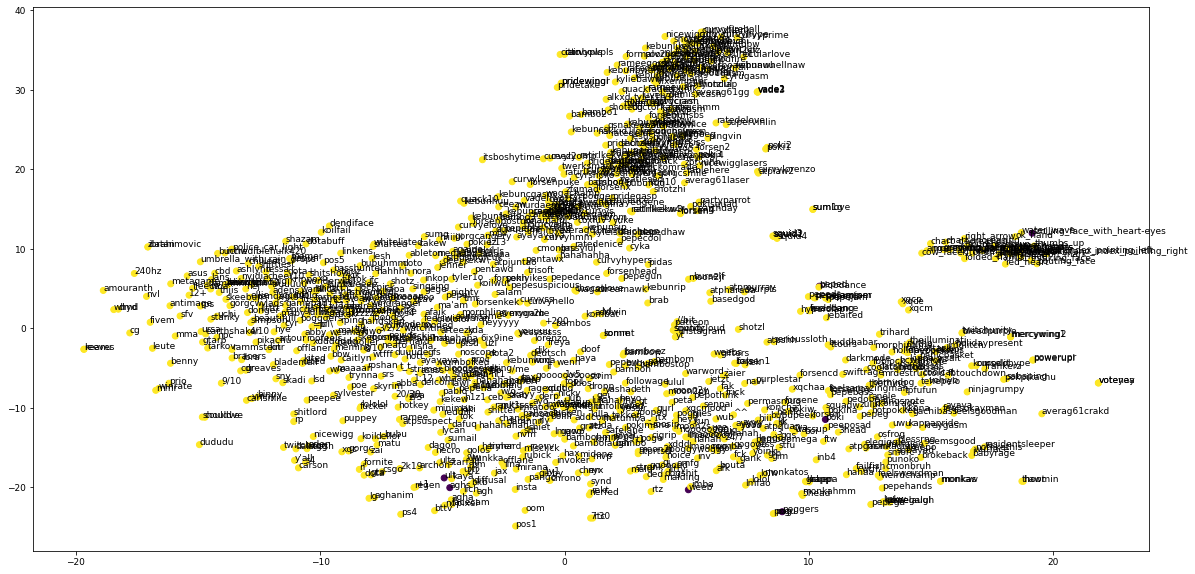

In [261]:
# Append words to list and plot in 2D using t-SNE (dimensionality reduction)
matplotlib.rcParams.update({'font.size': 9})
plt.figure(figsize=(20,10))

plt.scatter(tsne_df[0], tsne_df[1], c=clustering.labels_[-15988:-15000])

for i, txt in enumerate(words[-15988:-15000]):
    plt.annotate(txt, (tsne_df[0][i], tsne_df[1][i]))

plt.show()

In [262]:
pred_words = ['amazing', 'neutral']
clustering.predict([w2v_model.wv[w] for w in pred_words])

array([1, 1])

# Using FastText

In [263]:
fasttext_model = fasttext.load_facebook_model('D:\\Users\\brandon\\cc.en.300.bin') # Retrieved from fasttext.cc

In [264]:
fasttext_model.build_vocab(tokens, update=True, trim_rule=trim_rule)
print("built vocab")
fasttext_model.train(tokens, total_examples=len(tokens), epochs=5)
print("trained model")

built vocab
trained model


In [267]:
fasttext_model.wv.most_similar('pog', topn=10)

[('silverchair', 0.9599720239639282),
 ('superball', 0.9598502516746521),
 ('monter', 0.9590510129928589),
 ('silverstar', 0.9588357210159302),
 ('monted', 0.9587125778198242),
 ('pogu', 0.9583197236061096),
 ('x18baclegend', 0.9583165049552917),
 ('fbchallenge', 0.9581955075263977),
 ('starguardian', 0.9577870965003967),
 ('rainbowed', 0.9577358365058899)]

In [293]:
fasttext_model.wv.most_similar('multiplicity', topn=10)

[('multiplicities', 0.9941914677619934),
 ('multiplicativity', 0.9923574924468994),
 ('multiple-comparison', 0.9917681217193604),
 ('multivalence', 0.9914933443069458),
 ('multiplicator', 0.9910084009170532),
 ('multilayered', 0.9909431338310242),
 ('multiple-purpose', 0.9907950758934021),
 ('multiple-system', 0.9904494285583496),
 ('multiple-layered', 0.9903908371925354),
 ('multiple-core', 0.9901624321937561)]

In [295]:
fasttext_model.wv.most_similar('buff', topn=10)

[('buffs', 0.9842459559440613),
 ('buffed', 0.9782292246818542),
 ('spellpower', 0.9718294739723206),
 ('taunter', 0.9702704548835754),
 ('shadower', 0.9694654941558838),
 ('spellbender', 0.9693152904510498),
 ('hunter', 0.9680181741714478),
 ('Overpower', 0.9677962064743042),
 ('stoneskin', 0.9676737785339355),
 ('single-target', 0.9674260020256042)]

In [296]:
fasttext_model.wv.most_similar('hella', topn=10)

[('hellaciously', 0.985942542552948),
 ('realllll', 0.9857382774353027),
 ('reallll', 0.9857213497161865),
 ('reallyyyyy', 0.9852994084358215),
 ('reallllly', 0.9848520159721375),
 ('prettttty', 0.983670711517334),
 ('reallyyyy', 0.9826138615608215),
 ('insanely', 0.9823907613754272),
 ('pretttty', 0.9821714758872986),
 ('prettyyyy', 0.9821245670318604)]

In [299]:
fasttext_model.wv.most_similar('dmg', topn=10)

[('outdamage', 0.904596209526062),
 ('dmage', 0.9008456468582153),
 ('spelldamage', 0.897897481918335),
 ('dps', 0.8965327143669128),
 ('damage.', 0.8929290175437927),
 ('aoe', 0.8915732502937317),
 ('damage.Now', 0.8905525803565979),
 ('damage.NEW', 0.8904657959938049),
 ('damage.When', 0.8904025554656982),
 ('damage.-', 0.8903093934059143)]

In [268]:
fasttext_model.wv.n_similarity(['good'], ['pog'])

0.8944358

In [269]:
fasttext_model.save('D:\\Users\\brandon\\fasttext_model2')

In [270]:
ft_words = list(fasttext_model.wv.index_to_key[-12027:])
# Zip the words together with their vector representations
ft_word_vec_zip = zip(words, fasttext_model.wv[words])
# Cast to a dict so we can turn it into a DataFrame
ft_word_vec_dict = dict(ft_word_vec_zip)
ft_vector_df = pd.DataFrame.from_dict(ft_word_vec_dict, orient='index')
ft_vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,-0.430271,-0.044793,-0.000215,1.840587,-0.999658,0.088920,0.574130,-0.499956,0.142466,-0.007358,...,0.628198,0.011515,-2.145541,0.703372,-0.189072,0.189344,-0.280032,3.050101,-0.460248,-0.155150
",",0.125024,-0.107902,0.024502,-0.252864,0.105717,-0.018445,0.117679,-0.070073,-0.040075,-0.008026,...,0.064999,-0.039832,-0.137654,-0.043556,0.057811,0.018830,0.014819,0.230474,-0.069559,-0.021450
.,0.034232,-0.080141,0.116188,-0.396838,-0.014666,-0.053334,0.060631,-0.105187,0.000482,-0.036015,...,0.041499,-0.041801,-0.143957,-0.065888,-0.049115,-0.046745,-0.004242,0.542329,-0.062437,0.090048


In [319]:
ft_clustering = KMeans(n_clusters=3).fit(ft_vector_df)

In [320]:
ft_tsne = TSNE(n_components=2, init='random', perplexity=50)
ft_tsne_df = ft_tsne.fit_transform(ft_vector_df[:100])
ft_tsne_df = np.transpose(ft_tsne_df)

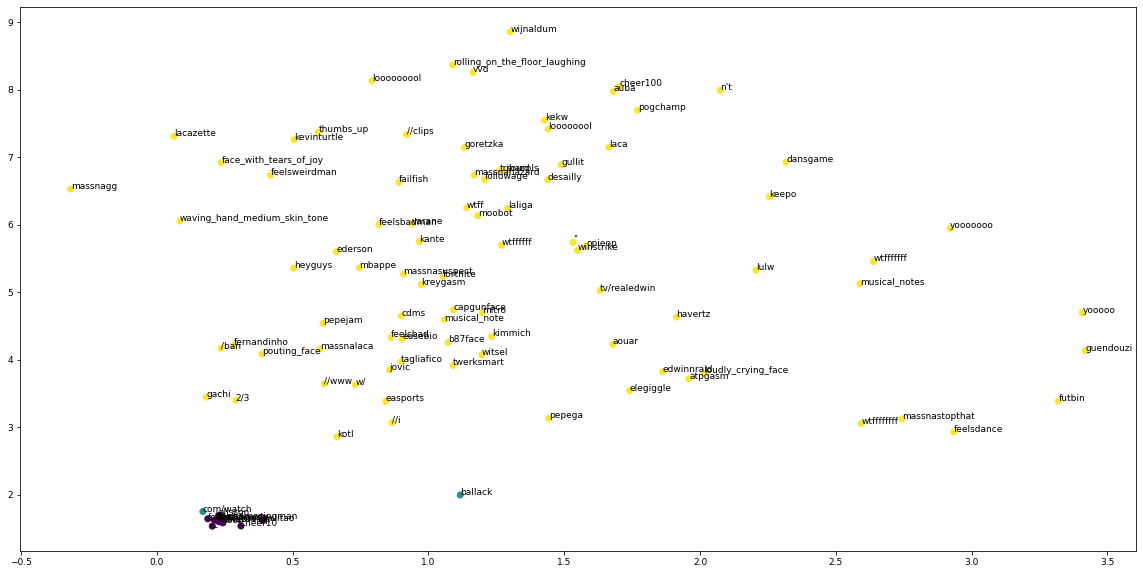

In [321]:
# Append words to list and plot in 2D using t-SNE (dimensionality reduction)
matplotlib.rcParams.update({'font.size': 9})
plt.figure(figsize=(20,10))

plt.scatter(ft_tsne_df[0], ft_tsne_df[1], c=ft_clustering.labels_[:100])

for i, txt in enumerate(ft_words[:100]):
    plt.annotate(txt, (ft_tsne_df[0][i], ft_tsne_df[1][i]))

plt.show()

In [322]:
pred_words = ['pog', 'trash']
ft_clustering.predict([fasttext_model.wv[w] for w in pred_words])

array([2, 2])

# FastText, no pretraining

In [330]:
new_fasttext_model = fasttext.FastText(vector_size=50, window=3, min_count=500)

In [331]:
new_fasttext_model.build_vocab(tokens, trim_rule=trim_rule)
print("built vocab")
new_fasttext_model.train(tokens, total_examples=len(tokens), epochs=20)
print("trained model")

built vocab
trained model


In [357]:
new_fasttext_model.wv.most_similar('tho', topn=10)

[('though', 0.904657244682312),
 ('actually', 0.7869613170623779),
 ('really', 0.7257518172264099),
 ('lol', 0.6974330544471741),
 ('because', 0.6905160546302795),
 ('cause', 0.6808242797851562),
 ('always', 0.6774188876152039),
 ('but', 0.6740723252296448),
 ('that', 0.6418427228927612),
 ('probably', 0.6342538595199585)]

In [358]:
new_fasttext_model.wv.most_similar('good', topn=10)

[('great', 0.8330361247062683),
 ('nice', 0.7744629979133606),
 ('bad', 0.7702003121376038),
 ('cool', 0.7414178252220154),
 ('funny', 0.6910631060600281),
 ('weird', 0.6777679324150085),
 ('awesome', 0.6614003777503967),
 ('sick', 0.6493255496025085),
 ('different', 0.6403501033782959),
 ('close', 0.634837806224823)]

In [368]:
new_fasttext_model.wv.most_similar('win', topn=10)

[('lose', 0.8917122483253479),
 ('kill', 0.7618730068206787),
 ('play', 0.7153026461601257),
 ('beat', 0.6955856084823608),
 ('die', 0.6837558746337891),
 ('pay', 0.6792885065078735),
 ('get', 0.6632591485977173),
 ('draw', 0.660702645778656),
 ('carry', 0.6598139405250549),
 ('bet', 0.6488164663314819)]

In [373]:
new_fasttext_model.wv.most_similar('monarch', topn=10)

[('month', 0.6913316249847412),
 ('money', 0.6585583686828613),
 ('hand', 0.6104462146759033),
 ('food', 0.6062106490135193),
 ('life', 0.593963623046875),
 ('land', 0.5700982213020325),
 ('card', 0.5621501207351685),
 ('which', 0.5558331608772278),
 ('second', 0.5529301166534424),
 ('emote', 0.5525431036949158)]

In [377]:
new_fasttext_model.wv.most_similar('op', topn=10)

[('broken', 0.8212491869926453),
 ('zerg', 0.6679832339286804),
 ('bad', 0.6334043741226196),
 ('mage', 0.6306077241897583),
 ('priest', 0.6245701313018799),
 ('perfect', 0.6184859275817871),
 ('hunter', 0.614777684211731),
 ('different', 0.5969237685203552),
 ('terran', 0.5873286128044128),
 ('trash', 0.5847864747047424)]

In [334]:
new_ft_words = list(new_fasttext_model.wv.index_to_key)
# Zip the words together with their vector representations
new_ft_word_vec_zip = zip(new_ft_words, new_fasttext_model.wv[new_ft_words])
# Cast to a dict so we can turn it into a DataFrame
new_ft_word_vec_dict = dict(new_ft_word_vec_zip)
new_ft_vector_df = pd.DataFrame.from_dict(new_ft_word_vec_dict, orient='index')
new_ft_vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
:,-2.551208,-1.627802,-10.237797,-2.382689,1.958460,-5.157619,-3.594641,1.738255,3.013094,-3.726139,...,2.450653,1.919668,-1.528514,3.198413,-4.064105,-3.260984,-3.088846,1.155180,2.621593,-5.502160
the,3.110213,-0.308790,-0.650132,-4.336584,-0.418773,0.553828,-0.930587,-1.210558,-0.821805,-0.258007,...,-2.211483,-1.488826,-2.190414,-1.832882,-1.303072,0.033123,-2.056958,0.357250,-1.250379,2.638096
i,-0.852987,7.727359,3.190943,7.639678,-0.369663,1.155832,1.902188,7.842340,-5.756130,3.960539,...,9.457060,-0.402804,0.170393,-8.795612,2.211887,3.778605,0.612016,-6.367751,-5.207655,2.787621


In [335]:
new_ft_clustering = KMeans(n_clusters=2, init=np.array([new_fasttext_model.wv['pog'], new_fasttext_model.wv['pepehands']])).fit(new_ft_vector_df)

C:\Users\brandon\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [342]:
new_ft_tsne = TSNE(n_components=2, init='random', perplexity=65)
new_ft_tsne_df = new_ft_tsne.fit_transform(new_ft_vector_df[1000:1100])
new_ft_tsne_df = np.transpose(new_ft_tsne_df)

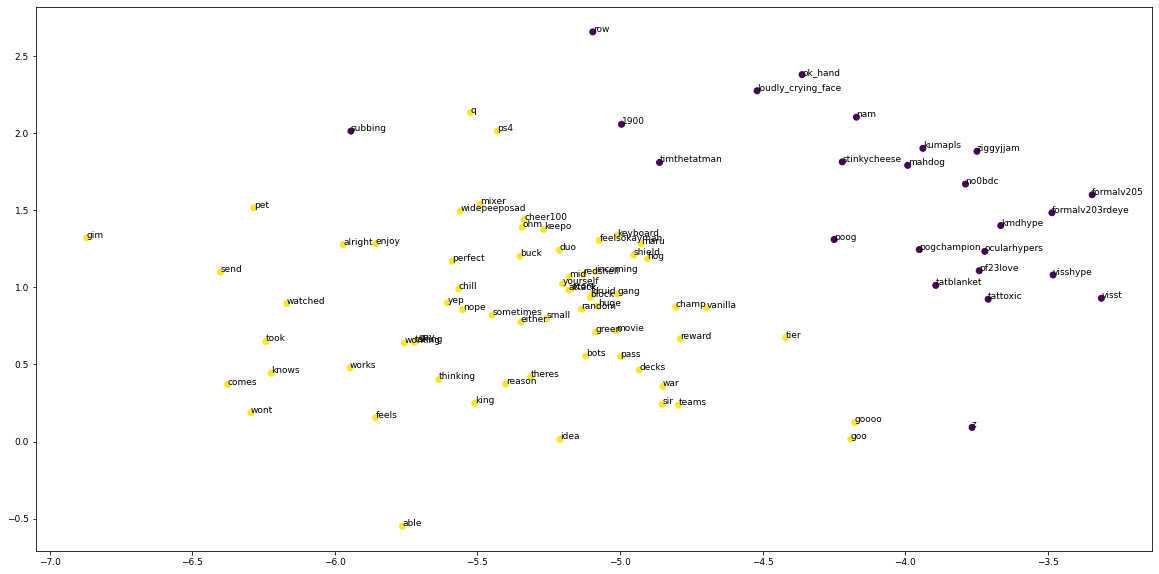

In [343]:
# Append words to list and plot in 2D using t-SNE (dimensionality reduction)
matplotlib.rcParams.update({'font.size': 9})
plt.figure(figsize=(20,10))

plt.scatter(new_ft_tsne_df[0], new_ft_tsne_df[1], c=new_ft_clustering.labels_[1000:1100])

for i, txt in enumerate(new_ft_words[1000:1100]):
    plt.annotate(txt, (new_ft_tsne_df[0][i], new_ft_tsne_df[1][i]))

plt.show()